In [ ]:
# Use the entire width of the screen if needed
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

---

Here is a good resource explaining the details of choosing t and C for the Hamiltonian Simulation and the controlled rotation respectively.

https://quantumcomputing.com/strangeworks/harrow-hassidim-lloyd-hhl-algorithm

---

In [234]:
# Reset the kernel if needed

%reset -f

In [235]:
# import the relevant libraries etc.
# set up the environment

from qiskit import *
import numpy as np


%matplotlib inline


In [236]:
# Define the problem (the tridiagonal matrix that we are interested in solving)

a = 1
b = 1/2

# Problem size
n_w = 5

In [237]:
# Define the eigenvalue register
n_l = 4

In [238]:
# Define the Trotterization
m = 1
# The order of the Trotter formula that we are using (shoot for the moon)

# Define the number of time steps we are taking
n_t = 10
t = 1
dt = t/n_t

In [239]:
# Define the registers for the problem
work_register = QuantumRegister(n_w,name='work')
eigenvalue_register = QuantumRegister(n_l,name='eignvalue')
ancilla = AncillaRegister(1,name='controlled_rotation')


In [240]:
# Define the initial state of the system
# Implement this later after the unitary of the system is shown to be working fine



In [241]:
# Make a seperate circuit for the unitary, later turn this whole thing into a circuit and 
# apply controlled versions of this

unitary_circuit = QuantumCircuit(work_register,name='U')

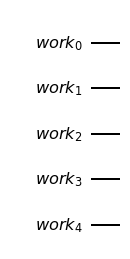

In [242]:
unitary_circuit.draw(output='mpl')

In [243]:
# Make seperate circuits for the different pieces H1 H2 etc

H1_circuit = QuantumCircuit(work_register,name='H1')

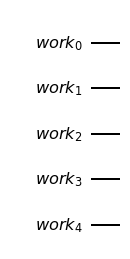

In [244]:
H1_circuit.draw(output='mpl')

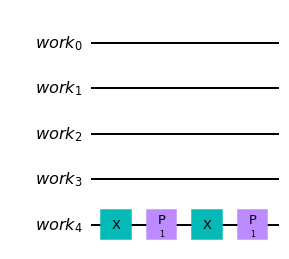

In [245]:
H1_circuit.x(n_w-1)
H1_circuit.p(a*t,n_w-1)
H1_circuit.x(n_w-1)
H1_circuit.p(a*t,n_w-1)
H1_circuit.draw(output='mpl')


In [246]:
H2_circuit = QuantumCircuit(work_register,name='H2')

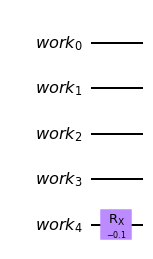

In [247]:
H2_circuit.rx(-2*b*dt,n_w-1)
H2_circuit.draw(output='mpl')

In [248]:
H3_circuit = QuantumCircuit(work_register,name='H3')

In [249]:
# H3 is made up of a bunch of C circuits
C_circuits = []

# We need to make a multi-controlled RX gate for each C
from qiskit.circuit.library.standard_gates import RXGate


for _C in range(1,n_w):
    _C_circuit = QuantumCircuit(work_register[-1-_C:],name='C{}'.format(_C))
    _C_circuit.cnot(1,0,ctrl_state=1)
    for _target in range(2,_C+1):
        _C_circuit.cnot(1,_target,ctrl_state=0)
    # Create the multi controlled Rx gate
    #if (_C-2)>=1:
    #    _rx_gate = RXGate(-2*b*dt).control(_C-2)
    #    _C_circuit.append(_rx_gate,[])
    _rx_gate = RXGate(-2*b*dt).control(_C)
    _controls_targets = [_x for _x in range(_C+1) if _x != 1]
    _controls_targets.append(1)
    print(_C)
    print(_controls_targets)
    _C_circuit.append(_rx_gate,_controls_targets)


        
    
    for _target in reversed(range(2,_C+1)):
        _C_circuit.cnot(1,_target,ctrl_state=0)
    _C_circuit.cnot(1,0,ctrl_state=1)
    C_circuits.append(_C_circuit)


1
[0, 1]
2
[0, 2, 1]
3
[0, 2, 3, 1]
4
[0, 2, 3, 4, 1]


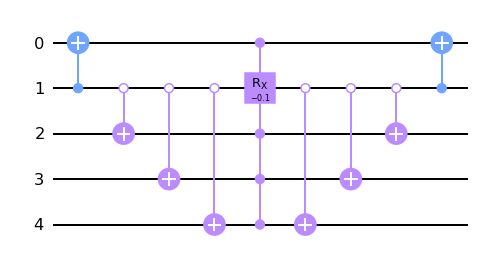

In [250]:
C_circuits[3].draw(output='mpl')

In [251]:
# Convert the C circuits to gates


In [252]:
# Append the C circuits to the overall H3 circuit
H3_circuit.barrier()
for _C in C_circuits:
    H3_circuit = H3_circuit + _C
    H3_circuit.barrier()


<ipython-input-252-a6ce200502ed>:4: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  H3_circuit = H3_circuit + _C


In [254]:
H3_circuit.draw()

░                        ░                                  ░      »
work_0: ─░────────────────────────░──────────────────────────────────░──────»
         ░                        ░                                  ░ ┌───┐»
work_1: ─░────────────────────────░──────────────────────────────────░─┤ X ├»
         ░                        ░ ┌───┐                      ┌───┐ ░ └─┬─┘»
work_2: ─░────────────────────────░─┤ X ├──────────■───────────┤ X ├─░───■──»
         ░ ┌───┐            ┌───┐ ░ └─┬─┘     ┌────┴─────┐     └─┬─┘ ░      »
work_3: ─░─┤ X ├─────■──────┤ X ├─░───■────o──┤ Rx(-0.1) ├──o────■───░──────»
         ░ └─┬─┘┌────┴─────┐└─┬─┘ ░      ┌─┴─┐└────┬─────┘┌─┴─┐      ░      »
work_4: ─░───■──┤ Rx(-0.1) ├──■───░──────┤ X ├─────■──────┤ X ├──────░──────»
         ░      └──────────┘      ░      └───┘            └───┘      ░      »
«                                              ░ ┌───┐               »
«work_0: ──────────────────────────────────────░─┤ X ├───────────────»
«                                        ┌───┐ ░ └─┬─┘               »
«work_1: ───────────────■────────────────┤ X ├─░───■────o────o────o──»
«                  ┌────┴─────┐          └─┬─┘ ░      ┌─┴─┐  │    │  »
«work_2: ──o────o──┤ Rx(-0.1) ├──o────o────■───░──────┤ X ├──┼────┼──»
«        ┌─┴─┐  │  └────┬─────┘  │  ┌─┴─┐      ░      └───┘┌─┴─┐  │  »
«work_3: ┤ X ├──┼───────■────────┼──┤ X ├──────░───────────┤ X ├──┼──»
«        └───┘┌─┴─┐     │      ┌─┴─┐└───┘      ░           └───┘┌─┴─┐»
«work_4: ─────┤ X ├─────■──────┤ X ├───────────░────────────────┤ X ├»
«             └───┘            └───┘           ░                └───┘»
«                                   ┌───┐ ░  ░ ┌───┐                      ┌───┐
«work_0: ─────■─────────────────────┤ X ├─░──░─┤ X ├──────────■───────────┤ X ├
«        ┌────┴─────┐               └─┬─┘ ░  ░ └─┬─┘     ┌────┴─────┐     └─┬─┘
«work_1: ┤ Rx(-0.1) ├──o────o────o────■───░──░───■────o──┤ Rx(-0.1) ├──o────■──
«        └────┬─────┘  │    │  ┌─┴─┐      ░  ░      ┌─┴─┐└────┬─────┘┌─┴─┐     
«work_2: ─────■────────┼────┼──┤ X ├──────░──░──────┤ X ├─────■──────┤ X ├─────
«             │        │  ┌─┴─┐└───┘      ░  ░      └───┘            └───┘     
«work_3: ─────■────────┼──┤ X ├───────────░──░─────────────────────────────────
«             │      ┌─┴─┐└───┘           ░  ░                                 
«work_4: ─────■──────┤ X ├────────────────░──░─────────────────────────────────
«                    └───┘                ░  ░